In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
import tqdm
import sys
import os
import gc
import argparse
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pickle
#计算shap值
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']

In [2]:
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('expand_frame_repr', False)  # 即“禁止换行”
# pd.set_option('display.precision', 2) #展示两位小数点
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
jy_df=pd.read_csv('data/账户交易信息.csv')
jy_df.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
jt_df=pd.read_csv('data/账户静态信息.csv')
jt_df.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
train_label=pd.read_csv('data/训练集标签.csv')
train_label.columns = ['账户代号','label']
test_df=pd.read_csv('data/test_dataset.csv')
test_df.columns = ['账户代号']## 读取数据

In [4]:
df_all=pd.concat([train_label,test_df])

In [5]:
df_all.head()

,账户代号,label
0,2029FF26D4E2CA79,0.00
1,09F5B90D46FB7CCE,1.00
2,E0C880EB18F4EFE8,1.00
3,ED8FFDCCF93C2F11,1.00
4,8D2F48B0BFC40AB2,1.00


# 特征处理

## 抹账处理

In [6]:
# 抹账交易序号
mz_index = [] ;

In [7]:
# 抹账数据处理
jy_mz_df=jy_df[jy_df['账户代号'].isin(jy_df[jy_df['交易金额']<0]['账户代号'].unique())].sort_values(by=['账户代号','交易日期','交易时间'],ascending=True)
jy_mz_df.index=range(len(jy_mz_df))
#待剔除数据
tc_idx=set()
for idx in jy_mz_df[jy_mz_df['交易金额']<0].index:
    for d in range(1,5):
        #print(idx)
        if -jy_mz_df.loc[idx,'交易金额']==jy_mz_df.loc[idx-d,'交易金额'] and jy_mz_df.loc[idx,'账户代号']==jy_mz_df.loc[idx-d,'账户代号']\
            and jy_mz_df.loc[idx,'对方账号']==jy_mz_df.loc[idx-d,'对方账号']:
                mz_index.append(idx-d) ;
                tc_idx.add(idx)
                tc_idx.add(idx-d)
                break
tc_idx=list(tc_idx)
jy_clean_df=jy_mz_df[~jy_mz_df.index.isin(tc_idx)]
jy_clean_df=pd.concat([jy_clean_df,jy_df[jy_df['交易金额']>=0]])

In [8]:
# 取出抹账的数据
df_mz = jy_mz_df.loc[mz_index , ['账户代号' , '交易金额']] ;
df_mz_agg = df_mz.groupby('账户代号')['交易金额'].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_mz_agg.columns = ['账户代号'] + ['抹账_'+ f for f in df_mz_agg.columns.values if f not in ['账户代号']]

In [9]:
df_mz_agg.head()

,账户代号,抹账_sum,抹账_count,抹账_mean,抹账_max,抹账_min,抹账_std,抹账_ptp
0,00037295453A928A,4600.00,1,4600.00,4600.00,4600.00,NaN,0.00
1,000AA77144DC1BCC,3.00,2,1.50,2.00,1.00,0.71,1.00
2,0046934E42BB38B7,99.00,1,99.00,99.00,99.00,NaN,0.00
3,005D7A6EF2DD90C9,11050.00,1,11050.00,11050.00,11050.00,NaN,0.00
4,0146ED21079D88CF,103648.00,2,51824.00,100000.00,3648.00,68131.15,96352.00


## 深夜交易

In [10]:
df_syjy = jy_clean_df[jy_clean_df['交易时间'] < "06:30:00"]
df_syjy = pd.concat([df_syjy , jy_clean_df[jy_clean_df['交易时间'] > "23:00:00"]])
# 共134101条

In [11]:
df_syjy.head()

,交易流水序号,账户代号,对方账号,借贷标志,交易金额,交易余额,对方行号,交易日期,交易时间,交易渠道,摘要代号,对方名称长度
12,7135AF28162520B3CD68B177D9BE4ECD,00037295453A928A,0F76A363EACBDEAF,0,4385.37,974.66,D41D8CD9,2020-03-06,00:30:24,757B505C,67D16D00,0
14,47F0FEC5A7B77BB768931962A9164B21,00037295453A928A,0F76A363EACBDEAF,1,2499.64,3336.30,D41D8CD9,2020-03-10,00:00:09,757B505C,D516B136,39
15,69EAC666C4B55A5E04504C3BB4291FC4,00037295453A928A,0F76A363EACBDEAF,1,2041.03,5377.33,D41D8CD9,2020-03-10,00:01:08,757B505C,D516B136,39
16,CB03E50464BDF55D11EA50A4C8D2E56F,00037295453A928A,0F76A363EACBDEAF,0,3425.65,1951.68,D41D8CD9,2020-03-10,00:34:49,757B505C,DD8EB9F2,0
18,66B88400E7942C516B3A4E6974A94F5E,00037295453A928A,EDE31EF0F69DC342,0,5000.00,4786.41,469F7281,2020-03-12,02:43:22,E96ED478,4E0CB6FB,12


In [12]:
df_syjy_agg = df_syjy.groupby('账户代号')['交易金额'].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_syjy_agg.columns = ['账户代号'] + ['深夜交易_'+ f for f in df_syjy_agg.columns.values if f not in ['账户代号']]

In [13]:
df_syjy_agg.head()

,账户代号,深夜交易_sum,深夜交易_count,深夜交易_mean,深夜交易_max,深夜交易_min,深夜交易_std,深夜交易_ptp
0,00037295453A928A,456020.92,133,3428.73,11600.00,1.00,2594.55,11599.00
1,0004CC075464D54B,4.00,4,1.00,1.00,1.00,0.00,0.00
2,000AA77144DC1BCC,85043.88,104,817.73,7000.00,0.10,1373.02,6999.90
3,001ABBF3373AFC5B,1057.00,5,211.40,549.00,1.00,288.52,548.00
4,0039E8B1DF35A675,39876.14,29,1375.04,10587.00,1.00,2686.17,10586.00


## 特征合并

In [14]:
df_all=df_all.merge(df_mz_agg,on='账户代号',how='left') ;
df_all=df_all.merge(df_syjy_agg,on='账户代号',how='left') ;


In [16]:
df_all.head()

,账户代号,label,抹账_sum,抹账_count,抹账_mean,抹账_max,抹账_min,抹账_std,抹账_ptp,深夜交易_sum,深夜交易_count,深夜交易_mean,深夜交易_max,深夜交易_min,深夜交易_std,深夜交易_ptp
0,2029FF26D4E2CA79,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80701.30,4.00,20175.33,60000.00,6840.15,26549.89,53159.85
1,09F5B90D46FB7CCE,1.00,100000.00,1.00,100000.00,100000.00,100000.00,NaN,0.00,4.00,4.00,1.00,1.00,1.00,0.00,0.00
2,E0C880EB18F4EFE8,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.00,3.00,100.67,300.00,1.00,172.63,299.00
3,ED8FFDCCF93C2F11,1.00,2.00,1.00,2.00,2.00,2.00,NaN,0.00,53930.00,8.00,6741.25,24400.00,300.00,10920.22,24100.00
4,8D2F48B0BFC40AB2,1.00,5003.50,2.00,2501.75,5000.00,3.50,3533.06,4996.50,473301.50,148.00,3197.98,20000.00,3.50,3708.12,19996.50


In [15]:
train_label = df_all[:len(train_label)] ;
test_label = df_all[len(train_label):] ;

In [59]:
def corr_filter(train_data,corr_threshold):
    corr_data=train_data.corr()
    corr_data=corr_data.where(np.triu(np.ones(corr_data.shape),k=1).astype(np.bool))
    high_corr=[column for column in corr_data.columns if any(corr_data[column].abs()>corr_threshold)]
    result=[c for c in train_data.columns if c not in high_corr]
    print("筛选后特征:",len(result))
    return result

In [16]:
cols = [f for f in train_label.columns if f not in ['账户代号','label']]

In [61]:
cols =corr_filter(train_label[cols],0.95)

筛选后特征: 10


In [17]:
cols

['抹账_sum',
 '抹账_count',
 '抹账_mean',
 '抹账_max',
 '抹账_min',
 '抹账_std',
 '抹账_ptp',
 '深夜交易_sum',
 '深夜交易_count',
 '深夜交易_mean',
 '深夜交易_max',
 '深夜交易_min',
 '深夜交易_std',
 '深夜交易_ptp']

In [34]:
def 对抗验证获取数据(df_train,df_test,threshold):
    # 定义新的Y
    
    
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1
    #print(df_train.columns)
    #print(df_test.columns)
    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])
    #print(df_adv.columns)
    #catecol_list_index=[list(df_train.columns).index(c) for c in df_train.select_dtypes(include=['category']).columns]
    # 通过抗验证中的模型，得到各个样本属于测试集的概率


    
    model_adv =  lgb.LGBMClassifier()
    model_adv.fit(df_adv.drop(['label','Is_Test'], axis=1), df_adv.loc[:, 'Is_Test'])
    preds_adv = model_adv.predict_proba(df_adv.drop(['label','Is_Test'], axis=1))[:, 1]
    
    df_train_copy = df_train.copy()
    df_train_copy['is_test_prob'] = preds_adv[:len(df_train)]

    # 根据概率排序
    df_train_copy = df_train_copy.sort_values('is_test_prob').reset_index(drop=True)

    # 将概率最大的20%作为验证集
    df_validation_2 = df_train_copy.iloc[int(threshold * len(df_train)):, ]
    df_train_2 = df_train_copy.iloc[:int(threshold * len(df_train)), ]
    return df_validation_2.drop(['is_test_prob','Is_Test'], axis=1)#,df_train_copy.drop(['Is_Test'],axis=1)
def 对抗验证获得新的列(df_train,df_test,threshold):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])

    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':32,'max_depth':10,'n_estimators':200,'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.08}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])
    #preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})

    im=im.sort_values(by='importance',ascending=False)
        
    new_cat=im.reset_index().loc[round(len(im)*threshold):,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return new_cat

In [35]:
new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.6)
cols=list(new_cat)
col_valid=cols.copy()
col_valid.append('label')
valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.8)

对抗验证后的特征数量为: 6


In [36]:
cols

['抹账_min', '抹账_mean', '抹账_max', '抹账_std', '抹账_count', '抹账_ptp']

In [31]:
def cv_model(clf, train_x, train_y, test_x, clf_name,valid_x):
    folds = 5
    seed = 2023
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])
    predict_valid = np.zeros(valid_x.shape[0])
    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }

            model = clf.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 8
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
            
            valid_dk_matrix = clf.DMatrix(valid_x)
            valid_pred= model.predict(valid_dk_matrix, ntree_limit=model.best_ntree_limit)
        if clf_name == "cat":
            model = clf(
                        n_estimators=10000,
                        random_seed=2023,
                        eval_metric='AUC',
                        learning_rate=0.05,
                        max_depth=7,
                        early_stopping_rounds=200,
                        metric_period=500,
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            valid_pred= model.predict_proba(valid_x)[:,1]
            
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        predict_valid +=valid_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
       
    return oof, predict,predict_valid,model

In [32]:
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid[cols])
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb',valid[cols])


NameError: name 'valid' is not defined

In [29]:
valid

NameError: name 'valid' is not defined

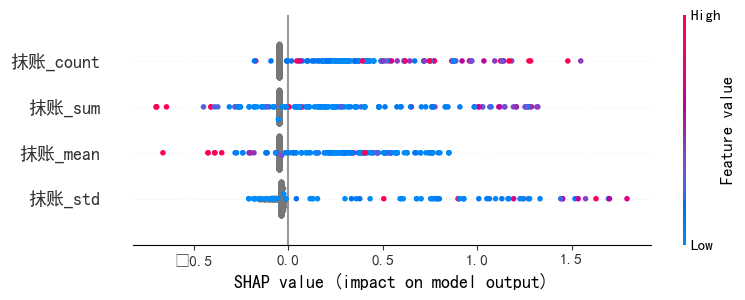

In [39]:

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(train_label[cols])
#shap.summary_plot(shap_values[1], train_label[cols])
shap.summary_plot(shap_values, train_label[cols])

In [40]:
wrap_features=pd.DataFrame()
wrap_features['cols']=cols
wrap_features['shap']=abs(shap_values).sum(axis=0)
wrap_features.sort_values(by='shap',ascending=False,inplace=True)
wrap_features.index=range(len(wrap_features))
wrap_features=wrap_features[:100]['cols']

In [41]:
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid.drop('label',axis=1))
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[wrap_features], train_label['label'], test_label[wrap_features], 'xgb',valid[wrap_features])

************************************ 1 ************************************
[0]	train-auc:0.59918	eval-auc:0.59069
[500]	train-auc:0.60268	eval-auc:0.58528
[0.592824074074074]
************************************ 2 ************************************
[0]	train-auc:0.60216	eval-auc:0.59144
[699]	train-auc:0.61155	eval-auc:0.57625
[0.592824074074074, 0.5927314814814815]
************************************ 3 ************************************
[0]	train-auc:0.60069	eval-auc:0.57778
[1000]	train-auc:0.60991	eval-auc:0.58181
[1113]	train-auc:0.60999	eval-auc:0.58125
[0.592824074074074, 0.5927314814814815, 0.5820833333333334]
************************************ 4 ************************************
[0]	train-auc:0.59631	eval-auc:0.61259
[828]	train-auc:0.60001	eval-auc:0.62500
[0.592824074074074, 0.5927314814814815, 0.5820833333333334, 0.6251851851851852]
************************************ 5 ************************************
[0]	train-auc:0.59502	eval-auc:0.60421
[510]	train-auc:0.

In [42]:
oof = xgb_oof
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.6,0.01):
    preds = (oof.reshape((-1))>threshold).astype('int')
    m = f1_score(train_label['label'].values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
    print(f'{threshold:.02f}, {m}')
print(f'最高分:{best_threshold:.2f}, {best_score}')

m_valid = f1_score(valid['label'].values, (xgb_valid_pred>best_threshold).astype('int'), average='macro')   

print(f'对抗验证分:{m_valid}')
# 0.47, 0.9150898680694286 # 0.86579572447
# 0.43, 0.9217716422203048 # 0.86697783
# 0.41, 0.9198568108353592 # 0.87674418605
# 0.40, 0.9231997065541027 # 0.87819025522
# 0.42, 0.913822737200522  # 0.87639132982 
# 0.40, 0.9148403872302214 # 0.88313184

0.40, 0.5609362389023407
0.41, 0.5609362389023407
0.42, 0.5609362389023407
0.43, 0.5615637559371575
0.44, 0.5621917729435953
0.45, 0.5625433125433126
0.46, 0.5631716484308594
0.47, 0.5597280195873096
0.48, 0.5779159981982984
0.49, 0.5763968314482992
0.50, 0.5660754244174642
0.51, 0.5537108939170795
0.52, 0.5322709308059944
0.53, 0.5157962934547252
0.54, 0.5046250814477491
0.55, 0.49964478266365053
0.56, 0.49710807941720614
0.57, 0.4975845410628019
0.58, 0.4853015127402666
0.59, 0.48306008159541847
最高分:0.48, 0.5779159981982984
对抗验证分:0.4312796208530806


In [43]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>0.42).astype('int')
result=test_label[['账户代号','label']]
result.columns=['zhdh','black_flag']
result.to_csv('submission20230305.csv', index=False)
result['black_flag'].value_counts()

PermissionError: [Errno 13] Permission denied: 'submission20230305.csv'